# Qual-IF-AI: Quality Control of ImmunoFluorescence Images using Artificial Intelligence

#### Qual-IF-AI is an automated tool for the identification and management of undesired artifacts in immunofluorescence images. Qual-IF-AI can detect five of the most common types of artifacts including: Air bubbles, External artifacts, Tissue folds, Out of focus areas, and antibody aggregates.
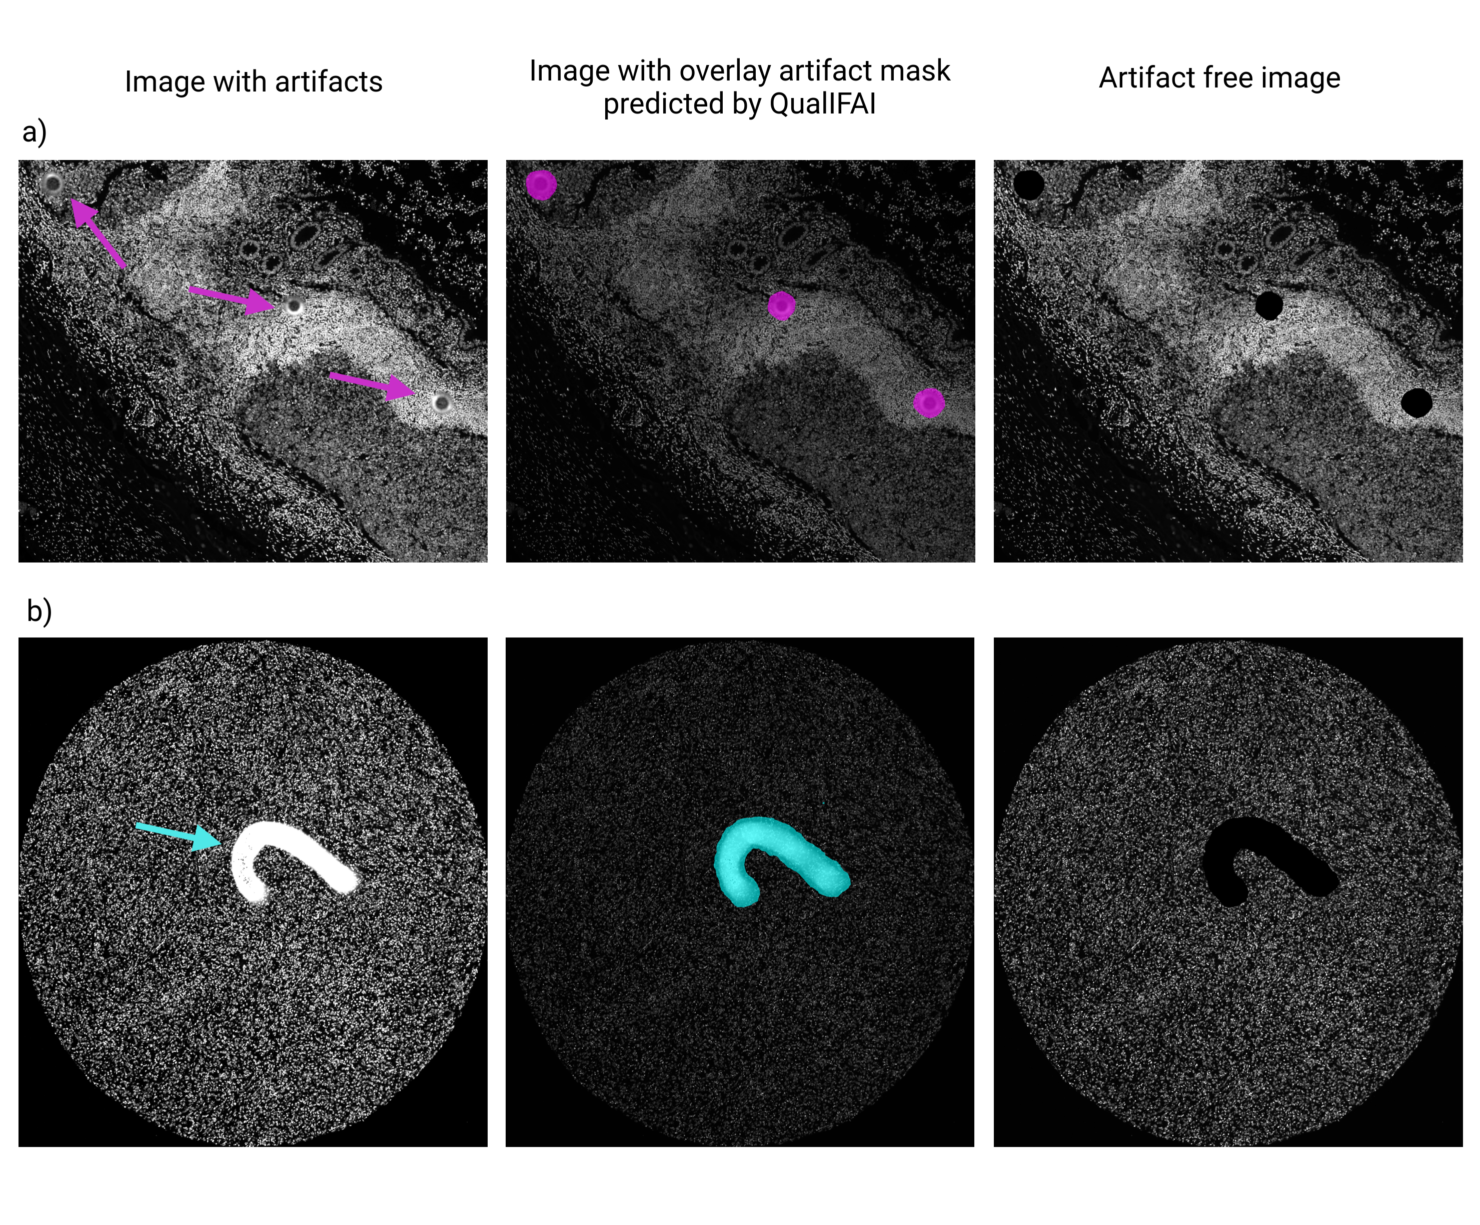



## Purpose


#### Fluorescent imaging has become an indispensable tool in various biological disciplines, enabling the study of protein dynamics, cellular functions, and neuronal activity, among others (Šachl and Amaro, 2023). With the recent development of multiplex immunofluorescent imaging, the simultaneous detection and quantification of multiple markers in a single tissue section has become feasible (Bosisio et al., 2022). The analysis of the  images generated with multiplex immunofluorescent imaging requires an extensive pipeline of preprocessing steps, including illumination correction, image registration (in the case of cyclic multiplexing methods), cell segmentation and autofluorescence subtraction before extracting quantitative single-cell measurements from the images (Antoranz et al., 2022; Eng et al., 2022; Schapiro et al., 2022). The quality of the input images is crucial to obtain reliable single-cell measurements and meaningful biological insights. Undesired artifacts, such as external artifacts (dust particles, hair shafts, fibers), air bubbles, antibody aggregates, out-of-focus (OOF) areas, and tissue folds are common not only in hematoxylin and eosin (H&E) images (Taqi et al., 2018) but also in fluorescent microscopy (Jiang et al., 2023). Dust particles, hair shafts, fibers, and air bubbles can get trapped during sample preparation or coverslipping.  Denatured antibodies can lead to antibody aggregation artifacts in the images. Misalignment of coverslip or inaccurate calculation of focus depth or tissue detachment during scanning can give rise to OOF areas. Suboptimal tissue embedding or tissue sectioning can lead to tissue folding or even complete tissue detachment from the slide (Taqi et al., 2018). These artifacts can significantly impact quantitative image analysis by including false positives and false negatives (Dimitriou et al., 2019; Wright et al., 2021). Traditionally, artifacts are manually annotated and removed from the images. With the rise of multiplexing, the number of images generated per experiment is drastically increasing, making manual annotation extremely laborious and time-consuming. Moreover, manual annotation is subjective and contingent on high intra- and inter-user variability (Brunt et al., 2022; van der Laak et al., 2021). To overcome these challenges, automated tools for detecting and managing artifacts in an unbiased and reproducible way are a necessity. Although some automated tools for detecting artifacts in histopathology  images exist (Hosseini et al., 2020; Janowczyk et al., 2019; Kanwal et al., 2024; Ke et al., 2023; Rodrigues et al., 2023), limited tools are available for fluorescent microscopy. 


#### Here, we present QUAL-IF-AI, an automated, accessible, and reliable tool for artifact detection and management in fluorescent microscopy, facilitating precise analysis of multiplexed immunofluorescence images. We demonstrate the utility of QUAL-IF-AI in detecting four of the most common types of artifacts in fluorescent imaging: air bubbles, tissue folds, external artifacts, and out-of-focus areas. We show how QUAL-IF-AI outperforms state-of-the-art methodologies in a variety of multiplexing platforms achieving over 85% of classification accuracy and more than 0.6 Intersection over Union (IoU) across all artifact types. 


## Workflow

#### Qual-IF-AI consists of two modules 1. Classification : Identification of image patches having artifacts. 2.Segmentation: Delineation of the area covered by the artifacts.
![Copy of GraphicalAbstract_Asier.png](<attachment:Copy of GraphicalAbstract_Asier.png>)
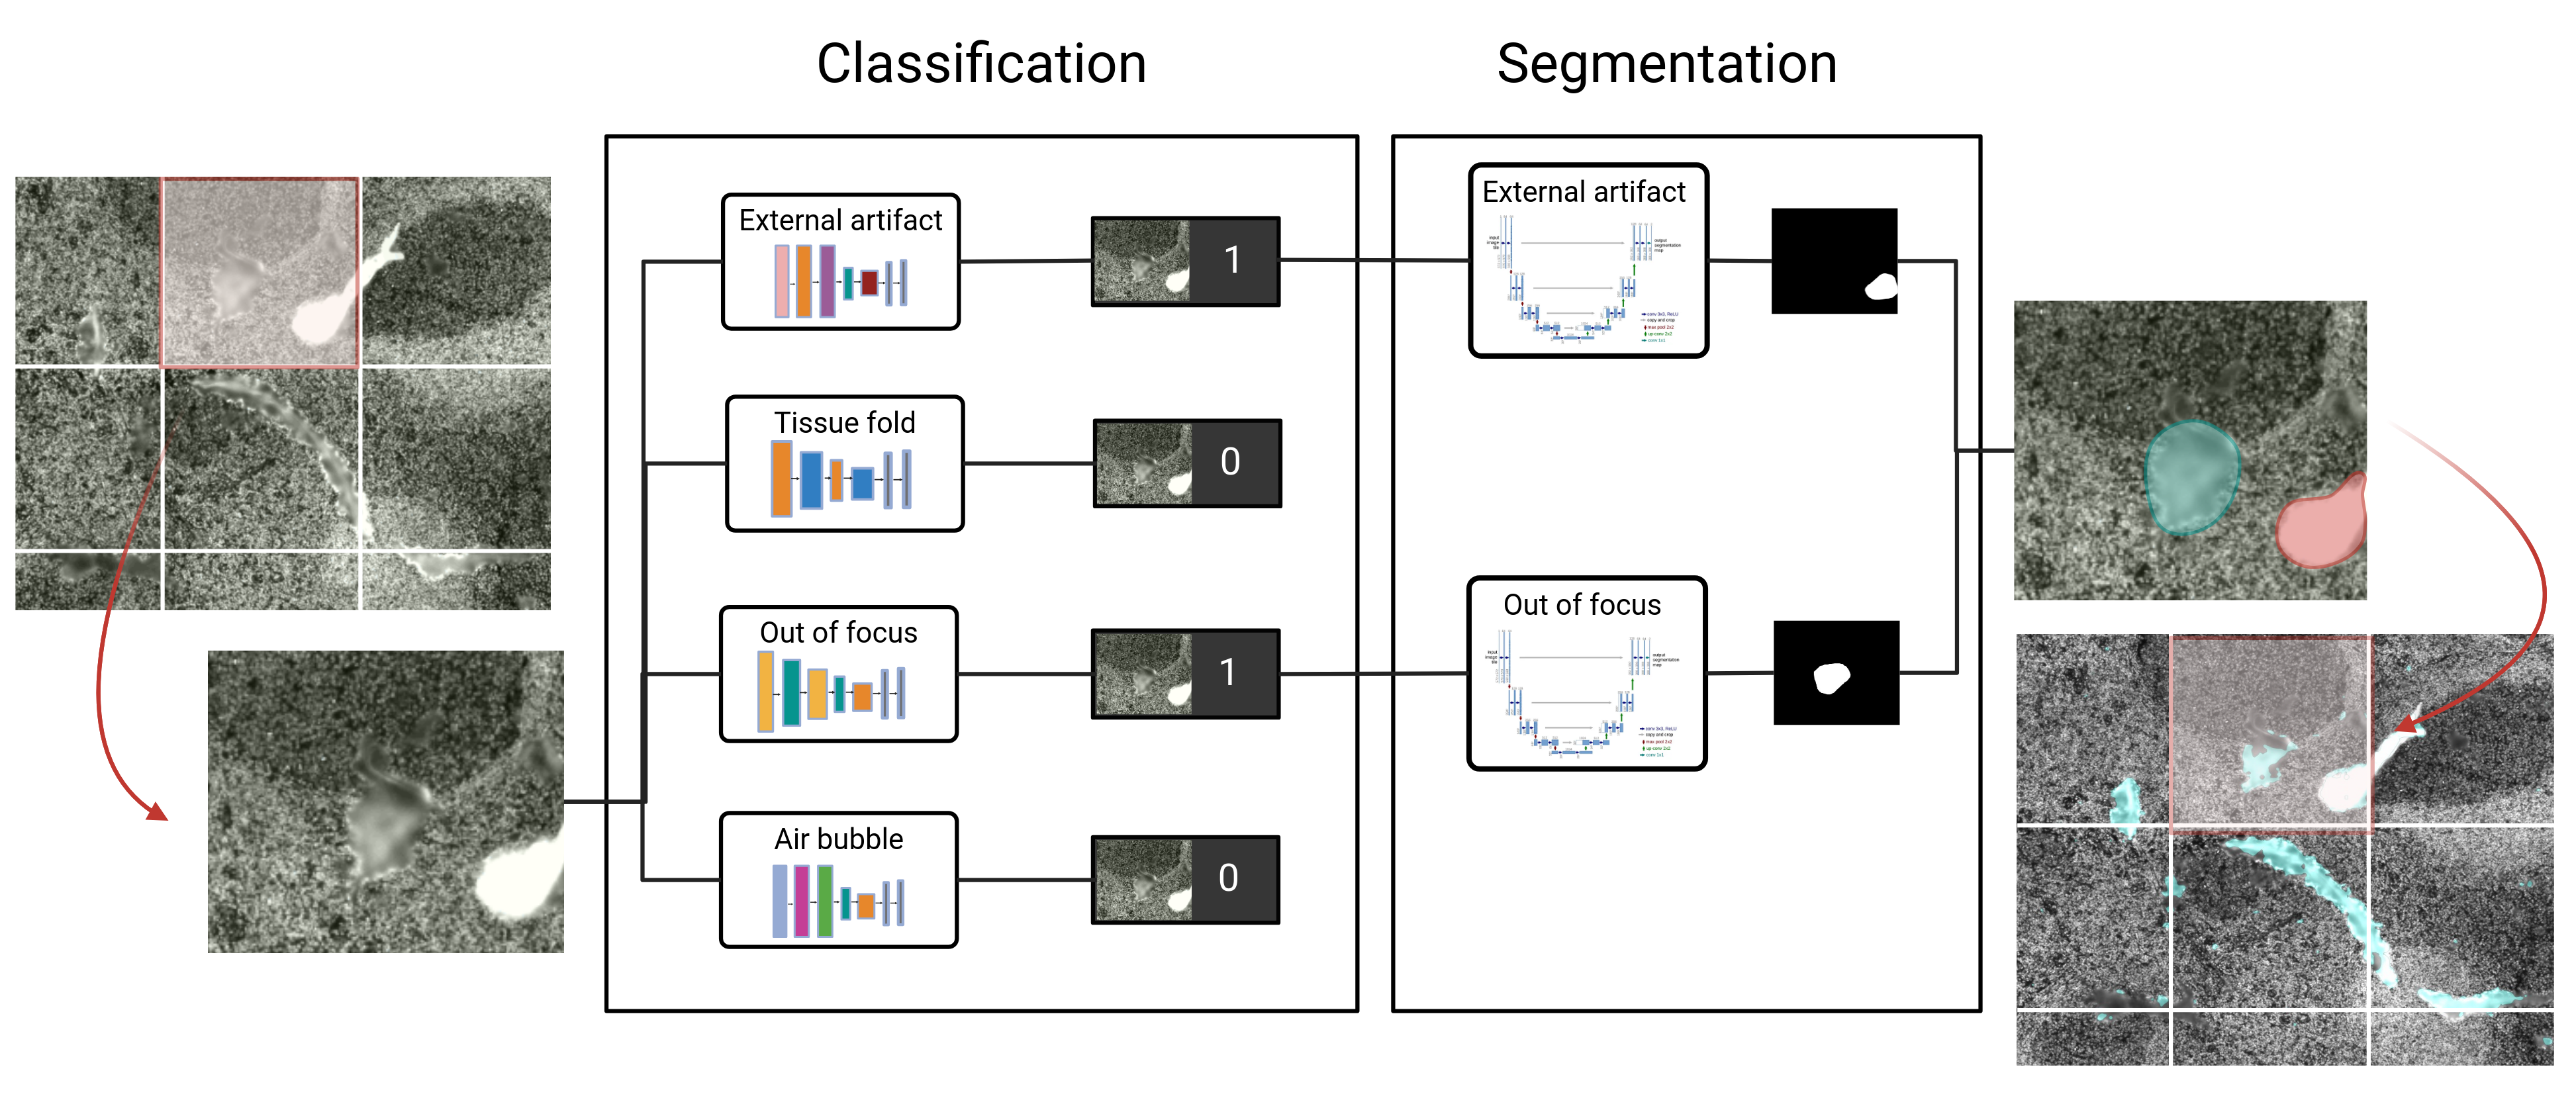

## Usage 

### In this section the usage of QUAL-IF-AI is described. In brief, input images are tesselated into patches of fixed size (512x512). Second, the tiles are classified between "clean" and "having artifacts". Third, the patches identified as "having artifacts" are segmented. Finally, the results are ensembled generating the final artifact mask. This mask is eventually applied to the input image to subtract the affected area for downstream analyses. This process will be ilustrated using an in-house-generated Diffuse large B cell lymphoma and kidney tissue images acquired with the MILAN [ref] multiplexing technology. The input image looks as follows:

![artifact images.jpg](<attachment:artifact images.jpg>)
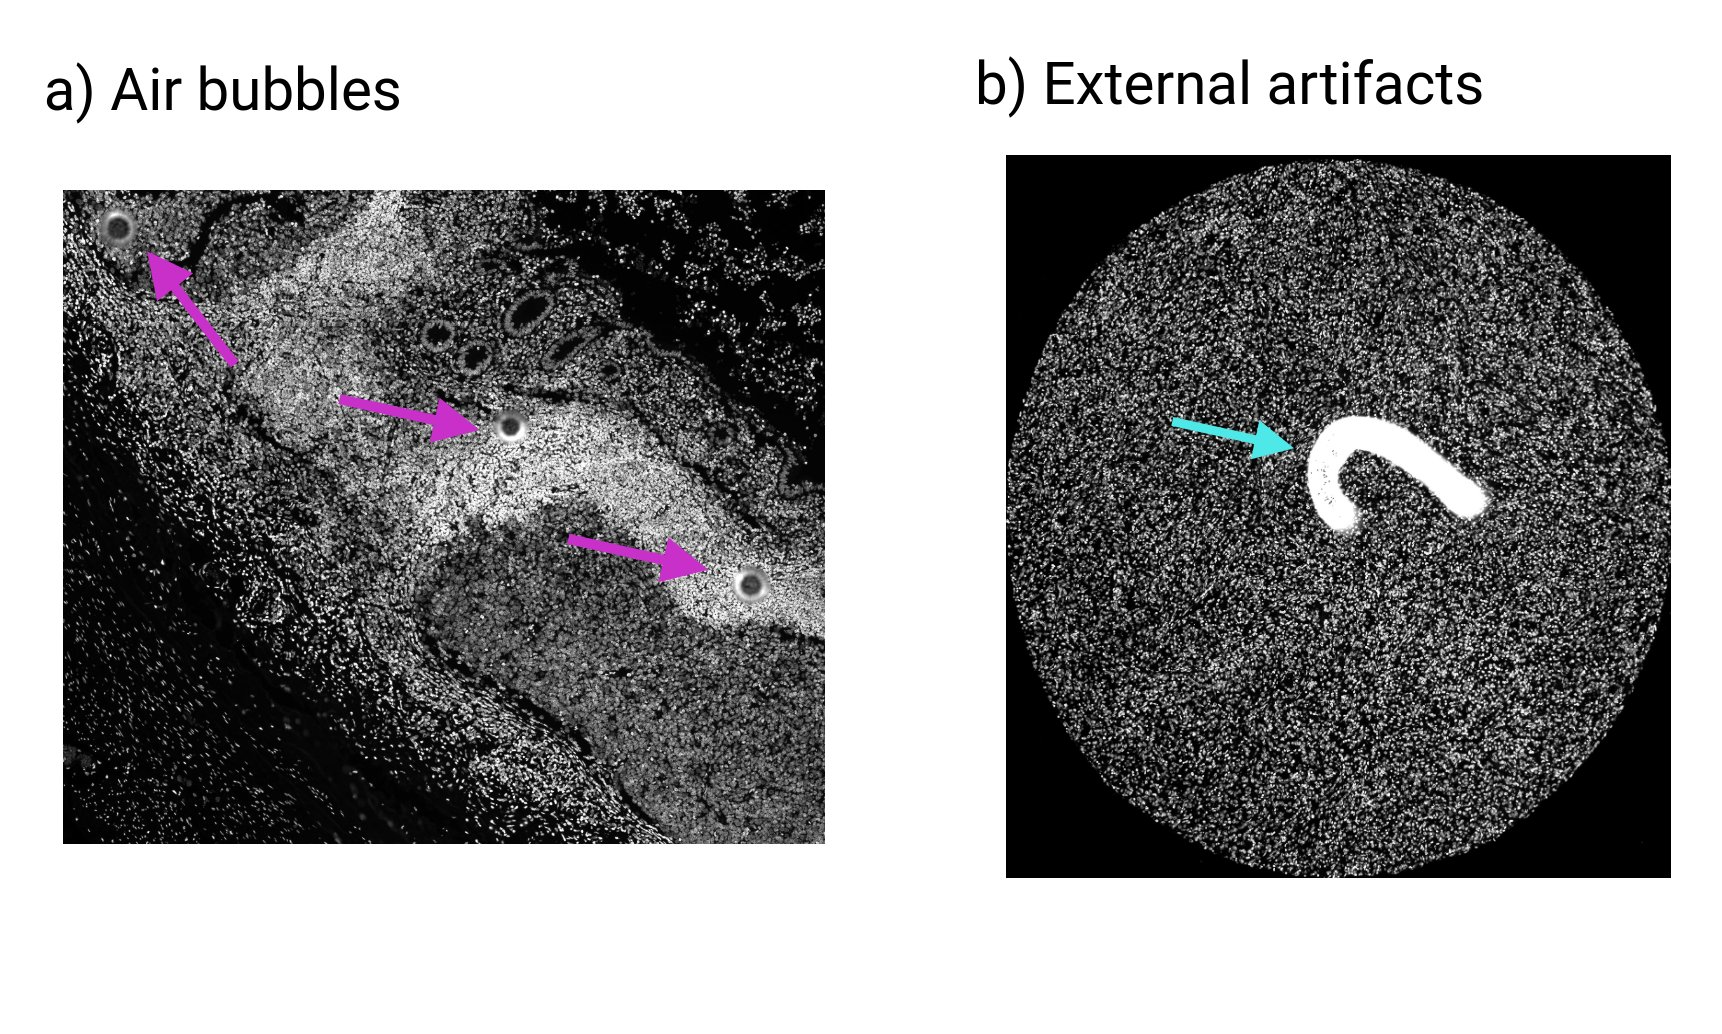

### Step 0 : Load functions
#### Step 0 is reading file with all the functions to implement Qual-IF-AI

In [1]:
%run QC_model_implementation

/mnt/data/QC_raw_images/Madhavi/github/git/code/QC_model_implementation:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-03-07 13:43:22.647572: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Segmentation Models: using `tf.keras` framework.


### Step1: Tessalate image
####  Qual-IF-AI models take as an input images of size 512 X 512.'split tiles' function tessalates input image into smaller tiles of size 512 X 512. Arguments : 1) input_image_path- Path to input images. 2)path_output_tiles- Path to save output tessaleted tiles

In [2]:
input_image_path=os.path.join(wd,'..','Images/')
path_output_tiles=os.path.join(wd,'..','cut_tiles')

split_tiles(input_image_path,path_output_tiles)

Img1_DAPI.tiff
Files are saved in /mnt/data/QC_raw_images/Madhavi/github/git/code/../cut_tiles
Img2_DAPI.tiff
Files are saved in /mnt/data/QC_raw_images/Madhavi/github/git/code/../cut_tiles


### Step2: Classification 
##### This function predicts probability of having 1)Air bubble 2)External artifact 3)Out of focus areas 4)Tissur folds 5)Antibody aggregations in each splitted tile. For predicting classification label, for each artifact, pre last vector output of the model is projected on a PCA template of images with artifact and images without artifacts. If 8 (n) out of 10 (k) nearest neighbors belong to one category, then that category label is given to the image tile else 'doubt' label is given. Each image tile i Classification label is given based on classification probability and number of  nearest neighbors of model  Arguments: 1) input path to split tiles 2)k:number of nearest neighbors to be accessed 3)n: how many neighbors should have same label 4)path to save output csv. 


In [3]:
path_output_tiles=os.path.join(wd,'..','cut_tiles')
csv_path=os.path.join(wd,'..','Data','classification_prediction.csv')
k=10
n=8
classification_prediction(path_output_tiles,csv_path,k,n)

Img1_DAPI
Img2_DAPI


### Step3: Segmentation

#### This function generates segmentation mask for every input images which classified as having artifact by the classification module. Arguments 1)artifact_list: Path to csv geberated by the classification module 2)out_dir: -path to the folder for saving output masks 3)img_path: Path to tessalated tiles

In [4]:
artifact_list=os.path.join(wd,'..','Data','classification_prediction.csv')
out_dir=os.path.join(wd,'..','mask')
img_path=os.path.join(wd,'..','cut_tiles')
segmentation(img_path,out_dir,artifact_list)

### Step4: Stitching mask tiles
####  This step stiches together all the masks from predicted tiles to match the size of original image. Arguments 1)raw_image_path: Path to original images 2)output_path: Path to output folder 3)input_image_path: Path to the folder where segmentation predictions of each image tile is saved

In [5]:
raw_image_path=out_dir=os.path.join(wd,'..','Images')
output_path=os.path.join(wd,'..','hard_stitch_masks')
input_image_path=os.path.join(wd,'..','mask')


merge_predictions(input_image_path,output_path,raw_image_path)

### Step 5: Generating artifact free images
#### In this final step artifacts from the images are removed using the masks generated previously

In [9]:
Mask_path=os.path.join(wd,'..','hard_stitch_masks')
Raw_image_path=os.path.join(wd,'..','Images')
output_path=os.path.join(wd,'..','Images_corrected')

artifacts_free_image(Mask_path,Raw_image_path,output_path)

### Wrapper function

#### This function generates all the steps together


In [ ]:
input_image_path=os.path.join(wd,'..','Images/')
output_path=os.path.join(wd,'..','Images_corrected')
QualIFAI(input_image_path,output_path)